In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import  TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_graph(y_test, y_pred, title):
    d = {'actual_price': y_test,'predicted_price': y_pred}
    df = pd.DataFrame(data=d)
    df['actual_var'] = df.actual_price.shift(1) - df.actual_price
    df['actual_var_sign'] = np.sign(df.actual_var)
    df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
    df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
    df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
    y_pred = pd.DataFrame(
        y_pred, index=y_test.index, columns=['price'])
    y_pred.plot(figsize=(16, 10))
    y_test.plot()
    plt.title(title)
    plt.legend(['predicted_price', 'actual_price'])
    plt.ylabel("Gold Week Price")
    plt.show()
    return df

In [3]:
gold = pd.read_csv('ouro2.csv')
gold.columns = ['data', 'today_price']

# inverte dataframe para poder fazer as médias móveis com os valores corretos
gold = gold[::-1]

gold['data']= pd.to_datetime(gold.data, dayfirst=True) #transform data into datetime
gold['last_week_price'] = gold.today_price.shift(1)
gold['next_week_price'] = gold.today_price.shift(-1)
filtro = np.where(gold['next_week_price'] > gold['today_price'], 1, 0)
gold['target_subida'] = filtro

gold['delta'] = gold.today_price - gold.last_week_price
gold['m3'] = gold.today_price.rolling(window=3).mean()
gold['m5'] = gold.today_price.rolling(window=5).mean()
gold['m7'] = gold.today_price.rolling(window=7).mean()
gold['m9'] = gold.today_price.rolling(window=9).mean()
gold.dropna(inplace=True)
gold.head(10)

,data,today_price,last_week_price,next_week_price,target_subida,delta,m3,m5,m7,m9
1087,2000-08-13,276.8,275.1,274.1,0,1.7,274.833333,276.46,278.085714,279.933333
1086,2000-08-20,274.1,276.8,277.0,1,-2.7,275.333333,275.26,276.785714,278.977778
1085,2000-08-27,277.0,274.1,273.3,0,2.9,275.966667,275.12,276.200000,277.522222
1084,2000-09-03,273.3,277.0,272.3,0,-3.7,274.800000,275.26,275.228571,276.422222
1083,2000-09-10,272.3,273.3,271.8,0,-1.0,274.200000,274.70,274.457143,275.444444
1082,2000-09-17,271.8,272.3,273.6,1,-0.5,272.466667,273.70,274.342857,274.522222
1081,2000-09-24,273.6,271.8,269.3,0,1.8,272.566667,273.60,274.128571,274.066667
1080,2000-10-01,269.3,273.6,272.4,1,-4.3,271.566667,272.06,273.057143,273.700000
1079,2000-10-08,272.4,269.3,271.2,0,3.1,271.766667,271.88,272.814286,273.400000
1078,2000-10-15,271.2,272.4,264.4,0,-1.2,270.966667,271.66,271.985714,272.777778


In [4]:
gold.tail()

,data,today_price,last_week_price,next_week_price,target_subida,delta,m3,m5,m7,m9
5,2021-05-09,1840.0,1833.5,1878.9,1,6.5,1814.433333,1801.08,1783.214286,1773.866667
4,2021-05-16,1878.9,1840.0,1905.3,1,38.9,1850.800000,1820.42,1804.442857,1788.655556
3,2021-05-23,1905.3,1878.9,1892.0,0,26.4,1874.733333,1845.50,1827.085714,1807.411111
2,2021-05-30,1892.0,1905.3,1879.6,0,-13.3,1892.066667,1869.94,1842.771429,1825.377778
1,2021-06-06,1879.6,1892.0,1868.0,0,-12.4,1892.300000,1879.16,1857.014286,1840.133333


### Normal series

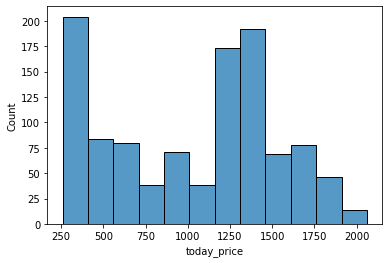

In [5]:
sns.histplot(gold.today_price)

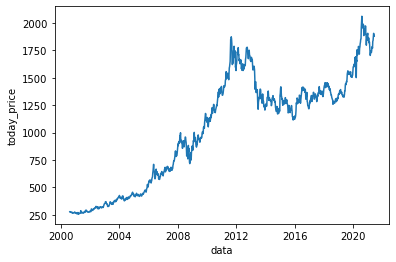

In [6]:
#print timeline graph
sns.lineplot(x=gold.data, y=gold.today_price)
#sns.lineplot(x=gold.data,y=gold.m7)
#sns.lineplot(x=gold.data,y=gold.m14)
#sns.lineplot(x=gold.data,y=gold.m21)

## Separação das entradas e saídas

In [7]:
X_train_base = gold.head(-100).drop(['data', 'next_week_price','target_subida'],axis=1).reset_index(drop=True)
y_train_base = gold.head(-100).filter(['next_week_price','target_subida'],axis=1).reset_index(drop=True)

print('Conjunto y de treino')
print("Número de linhas: {}".format(y_train_base.shape[0]))

# 100 amostras mais recentes fazem parte do conjunto de teste
X_test_base = gold.tail(100).drop(['data', 'next_week_price','target_subida'],axis=1).reset_index(drop=True)
y_test_base = gold.tail(100).filter(['next_week_price','target_subida'],axis=1).reset_index(drop=True)
print('Conjunto y de teste')
print("Número de linhas: {}".format(y_test_base.shape[0]))

Conjunto y de treino
Número de linhas: 987
Conjunto y de teste
Número de linhas: 100


In [8]:
X_train_base.head()

,today_price,last_week_price,delta,m3,m5,m7,m9
0,276.8,275.1,1.7,274.833333,276.46,278.085714,279.933333
1,274.1,276.8,-2.7,275.333333,275.26,276.785714,278.977778
2,277.0,274.1,2.9,275.966667,275.12,276.200000,277.522222
3,273.3,277.0,-3.7,274.800000,275.26,275.228571,276.422222
4,272.3,273.3,-1.0,274.200000,274.70,274.457143,275.444444


In [9]:
X_test_base.head()

,today_price,last_week_price,delta,m3,m5,m7,m9
0,1465.5,1450.9,14.6,1451.000000,1446.50,1427.985714,1408.400000
1,1460.4,1465.5,-5.1,1458.933333,1452.04,1439.200000,1422.877778
2,1485.3,1460.4,24.9,1470.400000,1459.74,1454.028571,1437.955556
3,1534.5,1485.3,49.2,1493.400000,1479.32,1468.571429,1454.911111
4,1549.2,1534.5,14.7,1523.000000,1498.98,1483.200000,1473.544444


In [10]:
# for train_index, test_index in cv:
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print()
#     Xtr, Xte = X_train.loc[train_index], X_train.loc[test_index]
#     ytr, yte = y_train.loc[train_index], y_train.loc[test_index]

In [11]:
# X_train = gold.head(-100).drop(['data','today_price','next_week_price'],axis=1)
# y_train = gold.next_week_price.head(-100)
# print('Conjunto y de treino')
# print("Número de linhas: {}".format(y_train.shape[0]))
# y_train.head()

### Definindo os conjuntos de entrada para treino e teste

In [12]:
X_test = X_test_base.filter(['delta','m3'],axis=1)
y_test = y_test_base.next_week_price
X_train = X_train_base.filter(['delta','m3'],axis=1)
y_train = y_train_base.next_week_price
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 2


,delta,m3
0,14.6,1451.000000
1,-5.1,1458.933333
2,24.9,1470.400000
3,49.2,1493.400000
4,14.7,1523.000000


## Baseline

In [13]:
baseline = X_test_base.query('delta > 0')
acertos_bl = baseline.shape[0]
print("Acertos: {}".format(acertos_bl))

Acertos: 59


In [14]:
# Repartindo o conjunto de treino em 5 partes 
# diferentes para validação dos modelos
tscv = TimeSeriesSplit(n_splits=5)

# Com delta e m3

### Linear Regressor

Best cv RMSE: 14.022009552772145
RMSE: 2293.53974


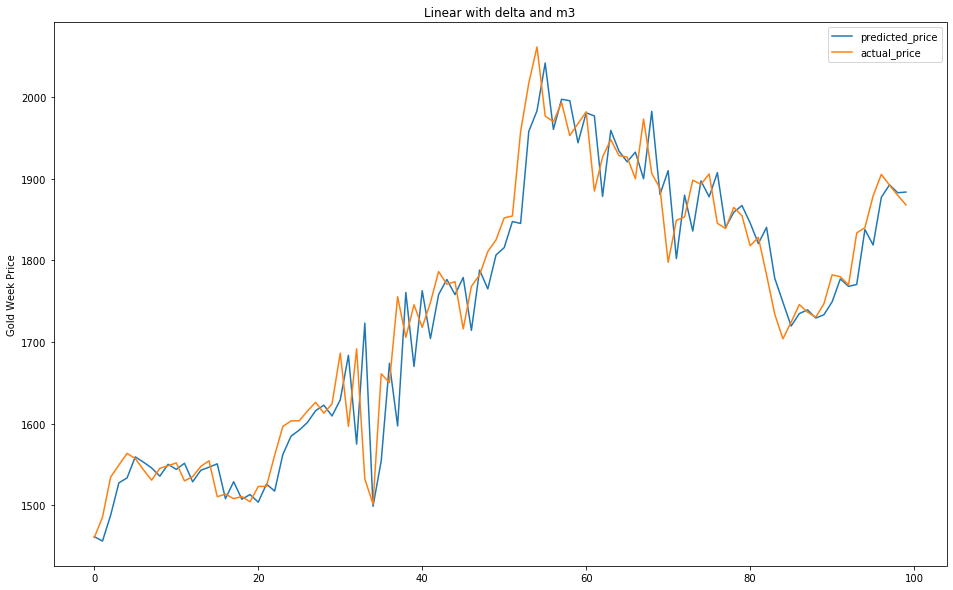

Número de linhas: 100
r2: 90.77
Acertos: 48


In [15]:
cvs = tscv.split(X_train)
l_regressor = LinearRegression()
linear_scores = cross_validate(l_regressor,
               X_train,
               y_train,
               cv=cvs,
               scoring=('r2', 'neg_mean_squared_error'))
linear_scores
print("Best cv RMSE:", np.sqrt(
    abs(linear_scores['test_neg_mean_squared_error']).min()))

l_regressor.fit(X_train, y_train)
y_pred = l_regressor.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)
df = plot_graph(y_test, y_pred, 'Linear with delta and m3')

print("Número de linhas: {}".format(df.shape[0]))
r2_score = l_regressor.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Rigde

best params: {'alpha': 2.5931206108924237e-10}
RMSE: 2293.53974


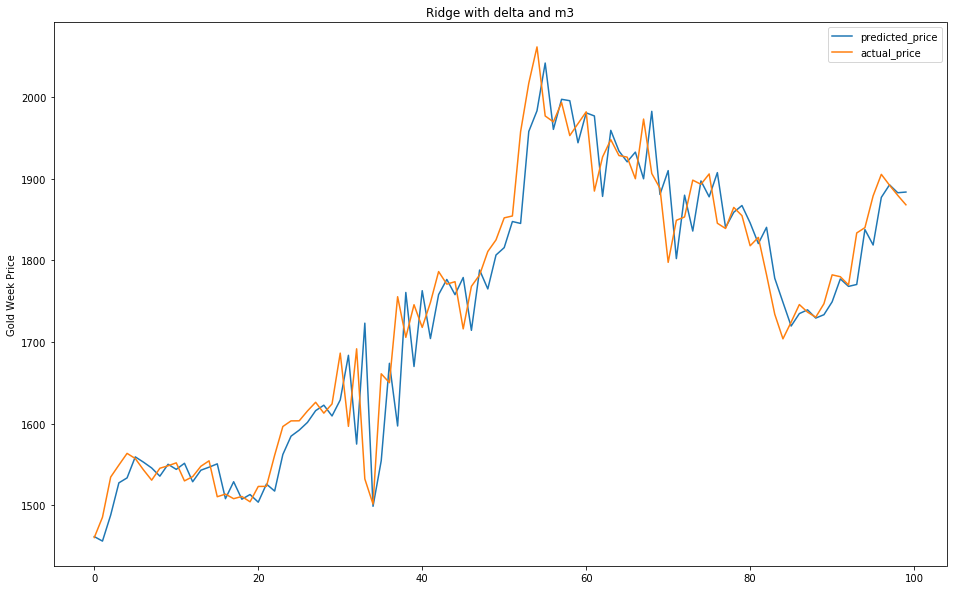

Número de linhas: 100
r2: 90.77
Acertos: 48


In [16]:
params = {'alpha': 10**(np.random.uniform(-10, 10, 1000))}
cvs = tscv.split(X_train)
grid_search = GridSearchCV(Ridge(), params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Ridge with delta and m3")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = ridge.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Lasso

best params: {'alpha': 1.0167606154967046e-05}
RMSE: 2293.53972


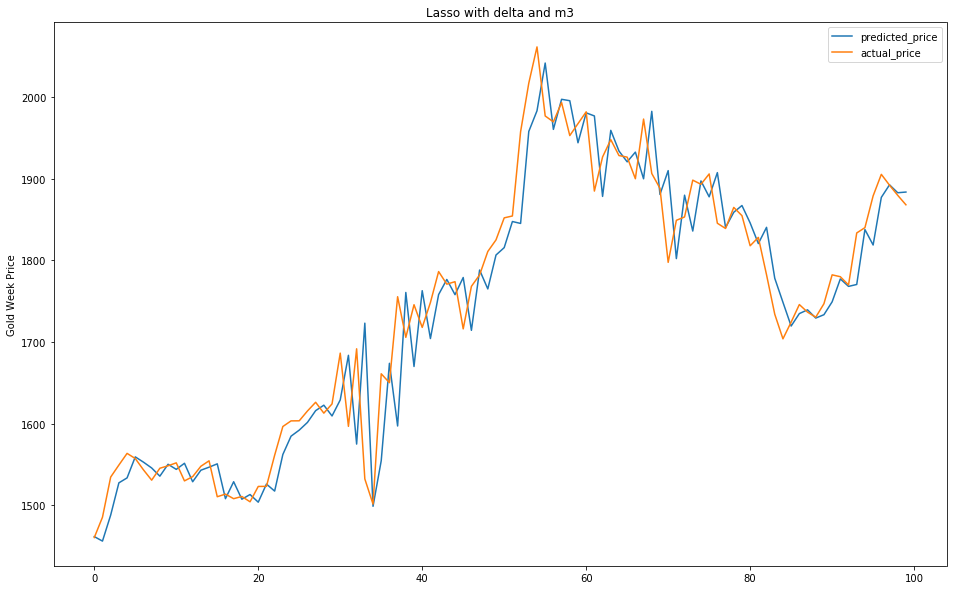

Número de linhas: 100
r2: 90.77
Acertos: 48


In [17]:
params = {'alpha': 10**(np.random.uniform(-5, 5, 1000))}
cvs = tscv.split(X_train)
grid_search = GridSearchCV(Lasso(max_iter=10000), params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

lasso = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Lasso with delta and m3")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = lasso.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Random Forest Regressor

best params: {'n_estimators': 150}
RMSE: 2293.53974


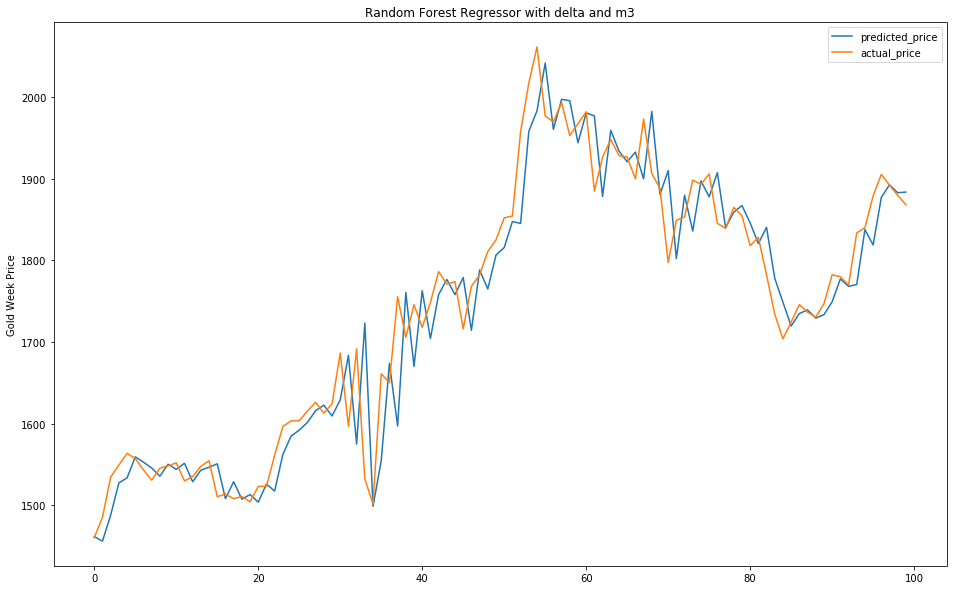

Número de linhas: 100
r2: 45.73
Acertos: 48


In [18]:
params = {'n_estimators': [10, 25, 50, 75, 100, 150]}

cvs = tscv.split(X_train)
grid_search = GridSearchCV(RandomForestRegressor(max_features=2),
                           params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

random_f = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'])
random_f.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Random Forest Regressor with delta and m3")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = random_f.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### SVR with kernel RBF


best params: {'C': 8148.787068482005, 'epsilon': 0.3, 'gamma': 0.04472246853627319}
RMSE: 431137.92020


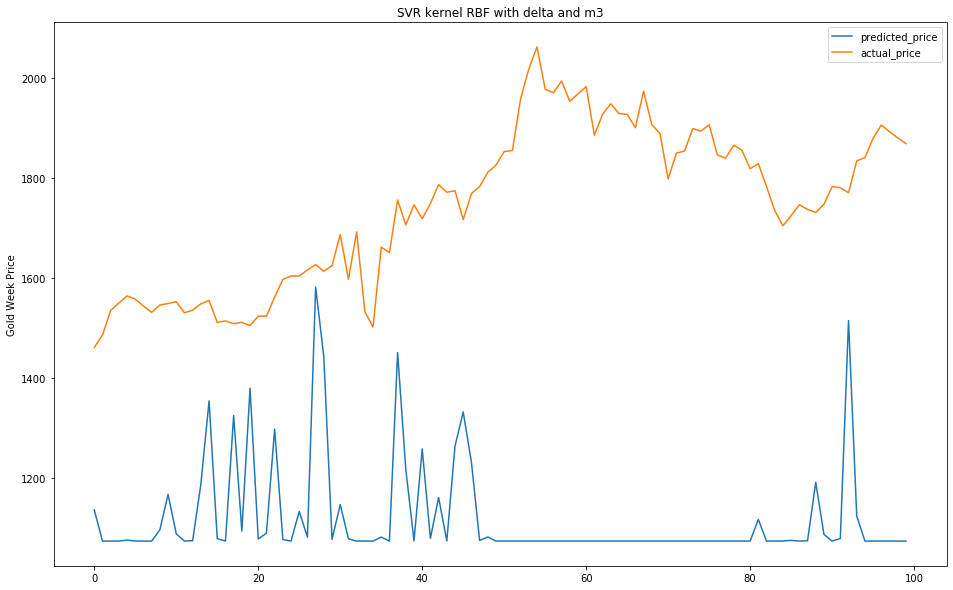

Número de linhas: 100
r2: -1634.39
Acertos: 35


In [19]:
params = {
    'epsilon': [0.0001, 0.001, 0.1, 0.2, 0.3],
    'gamma': 2**(np.random.uniform(-9, 3, 10)),
    'C': 2**(np.random.uniform(-5, 15, 10))
}

cvs = tscv.split(X_train)
grid_search = GridSearchCV(SVR(kernel='rbf'),
                           params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

svr = SVR(C=grid_search.best_params_['C'],
          epsilon=grid_search.best_params_['epsilon'],
          gamma=grid_search.best_params_['gamma'])
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "SVR kernel RBF with delta and m3")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = svr.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Linear SVR Regressor

best params: {'C': 182.4901851425851, 'epsilon': 0.001}
RMSE: 2458.69536


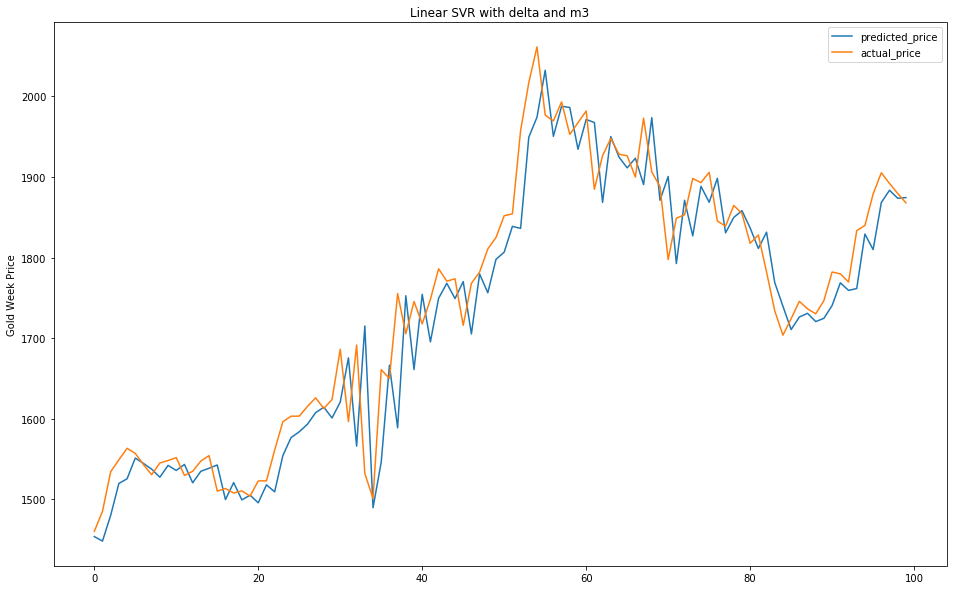

Número de linhas: 100
r2: 90.11
Acertos: 48


In [20]:
params = {
    'epsilon': [0.0001, 0.001, 0.1, 0.3, 0.5],
    'C': 2**(np.random.uniform(-5, 15, 10))}

cvs = tscv.split(X_train)
grid_search = GridSearchCV(LinearSVR(max_iter=10000),
                           params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

svr = LinearSVR(C=grid_search.best_params_['C'],
          epsilon=grid_search.best_params_['epsilon'])
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Linear SVR with delta and m3")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = svr.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

# Com delta e m7

In [21]:
X_test = X_test_base.filter(['delta','m7'],axis=1)
y_test = y_test_base.next_week_price
X_train = X_train_base.filter(['delta','m7'],axis=1)
y_train = y_train_base.next_week_price
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 2


,delta,m7
0,14.6,1427.985714
1,-5.1,1439.200000
2,24.9,1454.028571
3,49.2,1468.571429
4,14.7,1483.200000


### Linear Regressor

Best cv RMSE: 18.862406090327088
RMSE: 3599.10809


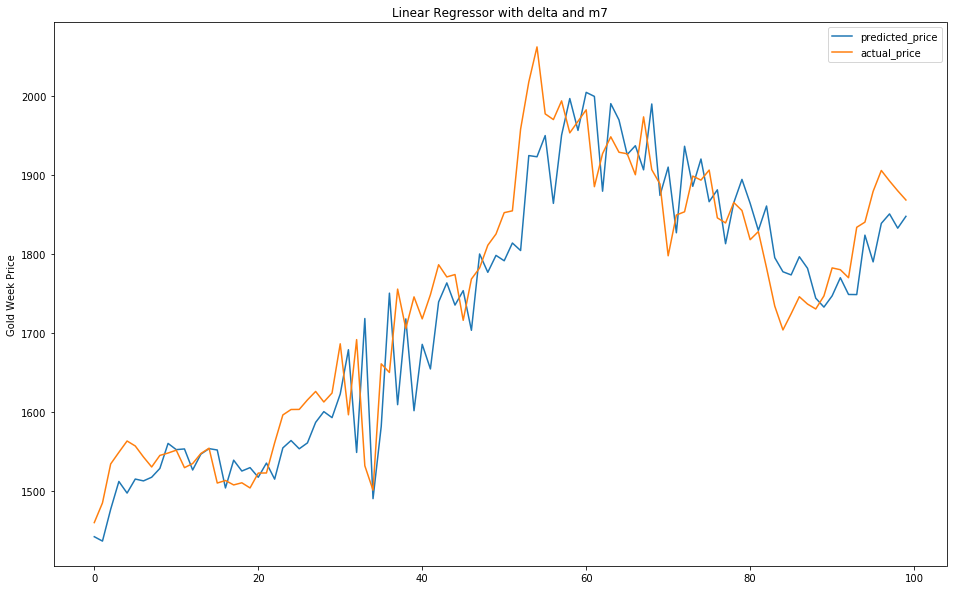

Número de linhas: 100
r2: 85.52
Acertos: 43


In [22]:
cvs = tscv.split(X_train)
l_regressor = LinearRegression()
linear_scores = cross_validate(l_regressor,
               X_train,
               y_train,
               cv=cvs,
               scoring=('r2', 'neg_mean_squared_error'))

linear_scores
print("Best cv RMSE:", np.sqrt(
    abs(linear_scores['test_neg_mean_squared_error']).min()))
l_regressor.fit(X_train, y_train)
y_pred = l_regressor.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Linear Regressor with delta and m7")
print("Número de linhas: {}".format(df.shape[0]))

r2_score = l_regressor.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Ridge

best params: {'alpha': 1.7266885090192117e-10}
RMSE: 3599.10809


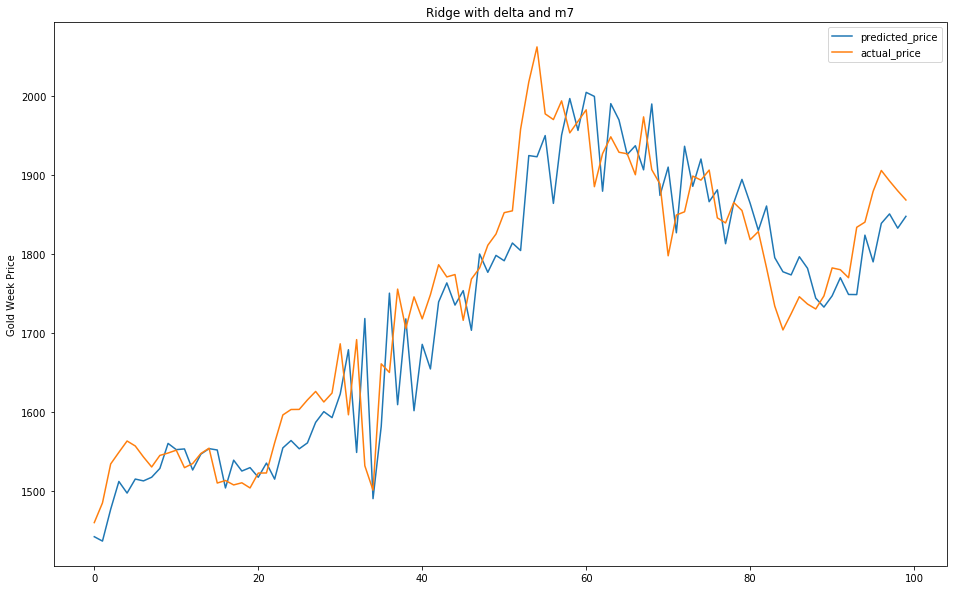

Número de linhas: 100
r2: 85.52
Acertos: 43


In [23]:
params = {'alpha': 10**(np.random.uniform(-10, 10, 1000))}
cvs = tscv.split(X_train)
grid_search = GridSearchCV(Ridge(), params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)
df = plot_graph(y_test, y_pred, "Ridge with delta and m7")
print("Número de linhas: {}".format(df.shape[0]))

r2_score = ridge.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Lasso

best params: {'alpha': 1.0057168262835896e-05}
RMSE: 3599.10806


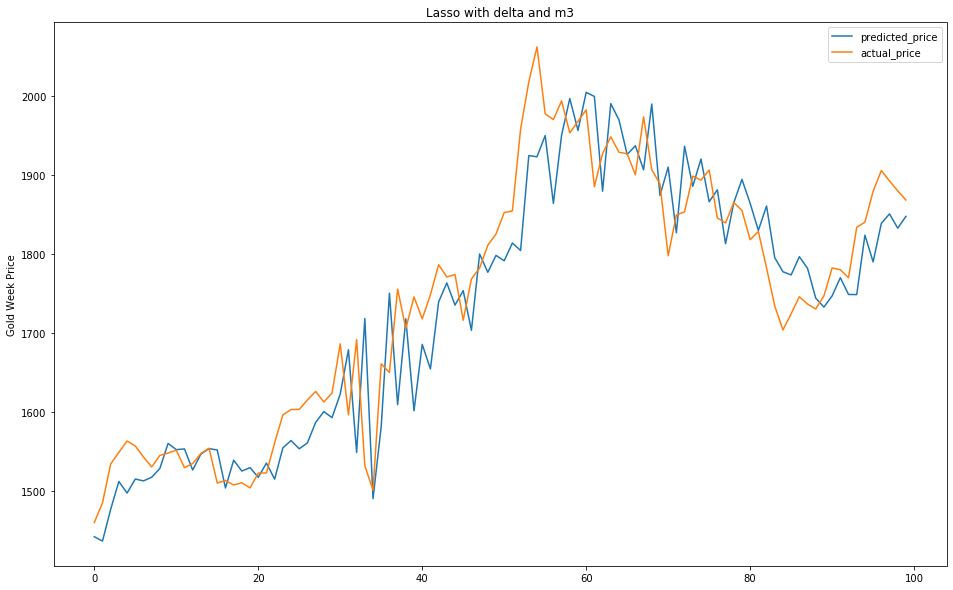

Número de linhas: 100
r2: 85.52
Acertos: 43


In [24]:
params = {'alpha': 10**(np.random.uniform(-5, 5, 1000))}
cvs = tscv.split(X_train)
grid_search = GridSearchCV(Lasso(max_iter=10000), params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

lasso = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Lasso with delta and m3")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = lasso.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Random Forest Regressor

best params: {'n_estimators': 25}
RMSE: 25413.98755


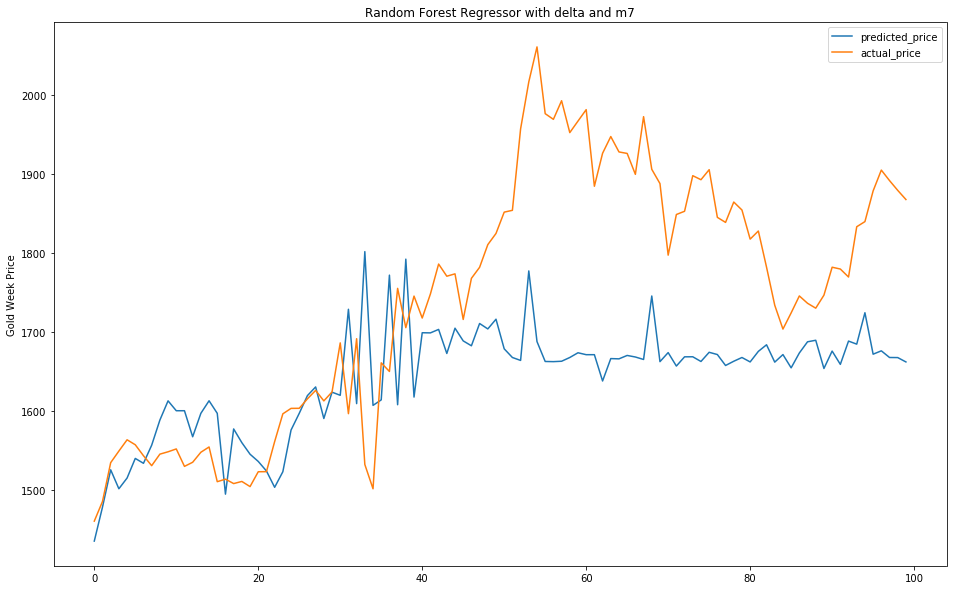

Número de linhas: 100
r2: -2.24
Acertos: 52


In [25]:
params = {'n_estimators': [10, 25, 50, 75, 100, 150]}

cvs = tscv.split(X_train)
grid_search = GridSearchCV(RandomForestRegressor(max_features=2),
                           params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

random_f = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'])
random_f.fit(X_train, y_train)
y_pred = random_f.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Random Forest Regressor with delta and m7")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = random_f.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### SVR Regressor with RBF

best params: {'C': 29124.57271668643, 'epsilon': 0.3, 'gamma': 0.030493856325371247}
RMSE: 417953.23641


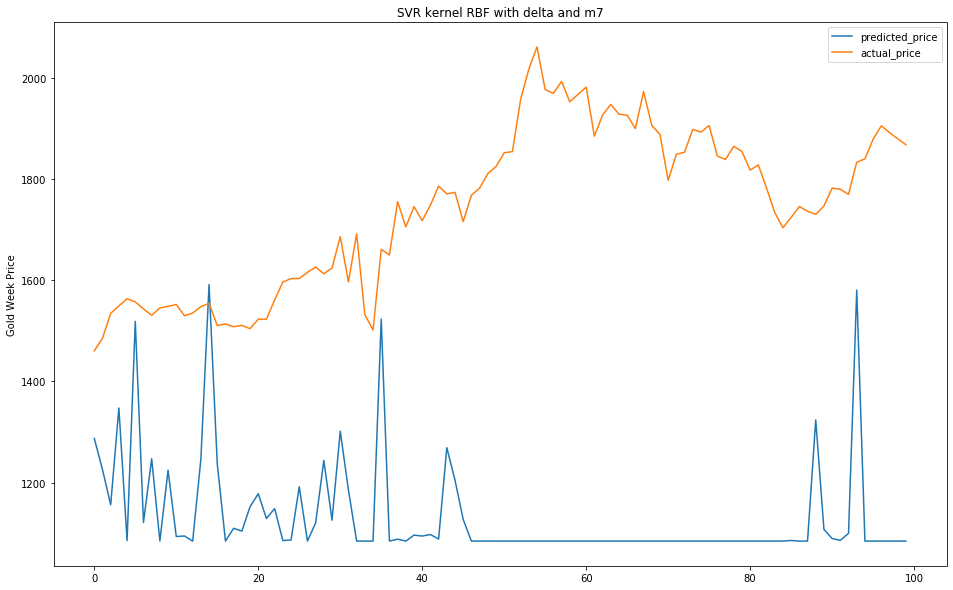

Número de linhas: 100
r2: -1581.35
Acertos: 29


In [26]:
params = {
    'epsilon': [0.0001, 0.001, 0.1, 0.2, 0.3],
    'gamma': 2**(np.random.uniform(-9, 3, 10)),
    'C': 2**(np.random.uniform(-5, 15, 10))
}

cvs = tscv.split(X_train)
grid_search = GridSearchCV(SVR(kernel='rbf'),
                           params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

svr = SVR(C=grid_search.best_params_['C'],
          epsilon=grid_search.best_params_['epsilon'],
          gamma=grid_search.best_params_['gamma'])
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "SVR kernel RBF with delta and m7")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = svr.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

### Linear SVR Regressor

best params: {'C': 0.3065467758727039, 'epsilon': 0.001}
RMSE: 6205.10308


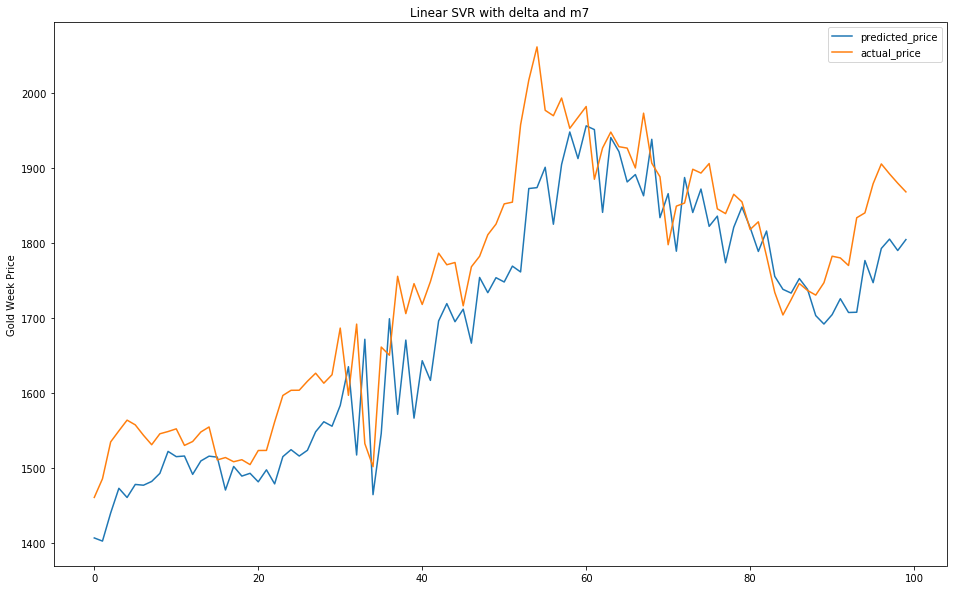

Número de linhas: 100
r2: 75.04
Acertos: 45


In [27]:
params = {
    'epsilon': [0.0001, 0.001, 0.1, 0.3, 0.5],
    'C': 2**(np.random.uniform(-5, 15, 10))}

cvs = tscv.split(X_train)
grid_search = GridSearchCV(LinearSVR(max_iter=10000),
                           params,
                           scoring='neg_mean_squared_error', cv=cvs)
grid_search.fit(X_train, y_train)
print('best params:', grid_search.best_params_)

svr = LinearSVR(C=grid_search.best_params_['C'],
          epsilon=grid_search.best_params_['epsilon'])
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("RMSE: %.5f"%rmse)

df = plot_graph(y_test, y_pred, "Linear SVR with delta and m7")
print("Número de linhas: {}".format(df.shape[0]))
r2_score = svr.score(X_test, y_test)*100
print("r2: {0:.2f}".format(r2_score))
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))